In [11]:
#!python3 -m spacy download en_core_web_sm
#!pip install gensim

In [4]:
#!pip install wordcloud
#!pip install xgboost
#!pip install torchvision
#!pip install tensorflow_text
#!pip install tensorflow_hub
#!pip install imblearn
# !pip install bert-for-tf2

In [2]:
#!pip install imblearn --use-feature=2020-resolver

In [1]:
!nvidia-smi

Thu Jun 16 20:52:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 6000     Off  | 00000000:18:00.0 Off |                  Off |
| 33%   23C    P8    10W / 260W |      3MiB / 24220MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro RTX 6000     Off  | 00000000:AF:00.0 Off |                  Off |
| 33%   

In [4]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import tldextract   # Accurately separates a URL's subdomain, domain, and public suffix
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix,precision_score,recall_score,accuracy_score,classification_report,f1_score

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
import nltk 
import spacy
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
import copy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from sklearn.metrics import f1_score
from pprint import pprint
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 1000)

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# foldr_pol_real = '//ueahome4/stusci1/psc21zcu/data/Documents/Dissertation//fake-news-detection-master//dataset//politifact//real//'
# foldr_pol_fake = '//ueahome4/stusci1/psc21zcu/data/Documents/Dissertation//fake-news-detection-master/dataset//politifact//fake//'
# foldr_gos_real = '//ueahome4/stusci1/psc21zcu/data/Documents/Dissertation//fake-news-detection-master/dataset//gossipcop//real//'
# foldr_gos_fake = '//ueahome4/stusci1/psc21zcu/data/Documents/Dissertation//fake-news-detection-master/dataset//gossipcop//fake//'
# #directory_list = [dir_pol_real,dir_pol_fake,dir_gos_real,dir_gos_fake]

In [ ]:
foldr_pol_real = 'input_dataset//fakenewsnet//politifact//real//'
foldr_pol_fake = 'input_dataset//fakenewsnet//politifact//fake//'
foldr_gos_real = 'input_dataset//fakenewsnet//gossipcop//real//'
foldr_gos_fake = 'input_dataset//fakenewsnet//gossipcop//fake//'
#directory_list = [dir_pol_real,dir_pol_fake,dir_gos_real,dir_gos_fake]

In [58]:
foldr_pol_real

'//ueahome4/stusci1/psc21zcu/data/Documents/Dissertation//fake-news-detection-master//dataset//politifact//real//'

##### Function to extract or convert JSON content to News Content format in dataframe

In [68]:
def json_to_newscontent(datapath):
    dictlist = []
    cols = ['url','text','title','authors','num_images','domain']
    folders = glob.glob(datapath+'/*')
    for index, subdir in enumerate(folders):
        path_file = glob.glob(subdir+'/*')
        #check whether file path is valid or not
        if len(path_file) == 1:
            file = open(path_file[0]).read()
            jsondata = json.loads(file)
            thedict = {'url':jsondata['url'],'title':jsondata['title'],'text':jsondata['text'],
                   'num_images':len(jsondata['images']),'authors':str(jsondata['authors'])}
            extrt_url = tldextract.extract(jsondata['url'])
            thedict['domain'] = extrt_url.domain
            dictlist.append(thedict)
    df=pd.DataFrame(dictlist,columns=cols)
    return df

##### Converting seperate dataframes for Politfact fake and real and Gossip fake and real

In [72]:
import time

# get the start time
st = time.time()

df_pol_real = json_to_newscontent(foldr_pol_real)
df_pol_fake = json_to_newscontent(foldr_pol_fake)
df_gos_real = json_to_newscontent(foldr_gos_real)
df_gos_fake = json_to_newscontent(foldr_gos_fake)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

##### Checking missing values in the dataframe

In [81]:
df_pol_real.isnull().sum()

url           0
text          0
title         0
authors       0
num_images    0
domain        0
dtype: int64

In [82]:
df_pol_fake.isnull().sum()

url           0
text          0
title         0
authors       0
num_images    0
domain        0
dtype: int64

In [83]:
df_gos_real.isnull().sum()

url           0
text          0
title         0
authors       0
num_images    0
domain        0
dtype: int64

In [84]:
df_gos_fake.isnull().sum()

url           0
text          0
title         0
authors       0
num_images    0
domain        0
dtype: int64

#### Removing rows having text column having no value

In [89]:
df_pol_real[df_pol_real['text']==''].count()

url           92
text          92
title         92
authors       92
num_images    92
domain        92
dtype: int64

In [90]:
df_pol_fake[df_pol_fake['text']==''].count()

url           29
text          29
title         29
authors       29
num_images    29
domain        29
dtype: int64

In [97]:
## Cleaned dataset
df_pol_real = df_pol_real.loc[df_pol_real["text"] != '' ]
df_pol_fake = df_pol_fake.loc[df_pol_fake["text"] != '' ]
df_gos_real = df_gos_real.loc[df_gos_real["text"] != '' ]
df_gos_fake = df_gos_fake.loc[df_gos_fake["text"] != '' ]

df_pol_real.reset_index(drop=True,inplace=True)
df_pol_fake.reset_index(drop=True,inplace=True)
df_gos_real.reset_index(drop=True,inplace=True)
df_gos_fake.reset_index(drop=True,inplace=True)

##### Storing dataframe to csv file 

In [100]:
df_pol_real.to_csv('df_pol_real.csv')
df_pol_fake.to_csv('df_pol_fake.csv')
df_gos_real.to_csv('df_gos_real.csv')
df_gos_fake.to_csv('df_gos_fake.csv')

#### Creating dataframe from csv

In [2]:
# creating a data frame
df_pol_real = pd.read_csv("C:\\Sobin\\Python_Exercis\\New_Python_Exercis\\FakeNews_Detection\\Dissertation_Work\\Updated\\df_pol_real.csv")
df_pol_fake = pd.read_csv("C:\\Sobin\\Python_Exercis\\New_Python_Exercis\\FakeNews_Detection\\Dissertation_Work\\Updated\\df_pol_fake.csv")
df_gos_real = pd.read_csv("C:\\Sobin\\Python_Exercis\\New_Python_Exercis\\FakeNews_Detection\\Dissertation_Work\\Updated\\df_gos_real.csv")
df_gos_fake = pd.read_csv("C:\\Sobin\\Python_Exercis\\New_Python_Exercis\\FakeNews_Detection\\Dissertation_Work\\Updated\\df_gos_fake.csv")

In [3]:
df_pol_fake.columns

Index(['Unnamed: 0', 'url', 'text', 'title', 'authors', 'num_images', 'domain'], dtype='object')

In [4]:
df_pol_real.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df_pol_fake.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df_gos_real.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
df_gos_fake.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

In [5]:
df_pol_real['Category'] = 'Politics' 
df_pol_fake['Category'] = 'Politics'
df_gos_real['Category'] = 'Gossips'
df_gos_fake['Category'] = 'Gossips'

##### Add response variable 'class' based on True=1 or Fake=0

In [6]:
df_pol_real['class'] = 0 #True
df_pol_fake['class'] = 1 #Fake
df_gos_real['class'] = 0
df_gos_fake['class'] = 1

In [7]:
df_list = [df_pol_real,df_pol_fake,df_gos_real,df_gos_fake]

In [8]:
#combine df's into one
df = pd.concat(df_list).reset_index(drop=True)
total_rows = df.shape[0]

In [9]:
total_rows

20362

In [10]:
df.columns

Index(['url', 'text', 'title', 'authors', 'num_images', 'domain', 'Category', 'class'], dtype='object')

In [11]:
df['class'].value_counts() / df.shape[0]*100

0    75.193989
1    24.806011
Name: class, dtype: float64

In [12]:
df = pd.concat(df_list).reset_index(drop=True)
total_rows = df.shape[0]

In [13]:
pd.set_option('display.max_colwidth', 200)
#pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)

### EDA - Data Analysis

In [14]:
df.head(2)

,url,text,title,authors,num_images,domain,Category,class
0,http://www.senate.gov/legislative/LIS/roll_call_lists/roll_call_vote_cfm.cfm?congress=111&session=1&vote=00174,"Roll Call Vote 111th Congress - 1st Session\n\nVote Summary\n\nQuestion: On the Amendment (Durbin Amdt. No. 1014 ) Vote Number: 174 Vote Date: April 30, 2009, 02:47 PM Required For Majority: 3/5 V...",U.S. Senate: U.S. Senate Roll Call Votes 111th Congress,[],6,senate,Politics,0
1,http://www.politico.com/news/stories/0509/22413.html,"At a press conference addressing Carrie Prejean’s disputed title in the Miss USA competition, pageant owner Donald Trump compared Prejean’s stated views on gay marriage to Obama’s.\n\n“It’s the sa...",Trump on Prejean: Same as Obama,[],2,politico,Politics,0


In [15]:
df.pivot_table(index = 'domain', columns = 'class', values = 'url', aggfunc='count').fillna(0).astype(int).sort_values(1,axis=0,ascending=False).head(100)

class,0,1
domain,,
archive,1112,767
people,1537,216
dailymail,769,194
radaronline,19,172
eonline,0,154
usmagazine,562,147
imdb,0,145
hollywoodlife,13,126
wikipedia,618,124


In [16]:
df.loc[df['domain']=='archive'].head(2)

,url,text,title,authors,num_images,domain,Category,class
3,https://web.archive.org/web/20090514023215/http://republicanleader.house.gov/News/DocumentSingle.aspx?DocumentID=125333,"House GOP Introduces Keep Terrorists Out of America Act\n\nWashington, May 7 - House Republicans today introduced the Keep Terrorists Out of America Act, legislation aimed at stopping the transfer...",House GOP Introduces Keep Terrorists Out of America Act,[],8,archive,Politics,0
4,https://web.archive.org/web/20061116002411/http://www.forbes.com:80/2006/04/15/prison-supermax-ross_cx_jr_06slate_0418super.html?,'); //--> E-mail | Print | Comments | Request Reprints | E-Mail Newsletters | My Yahoo! | RSS\n\nBlank Slate\n\nIs The End In Sight For Supermax?\n\nJeffrey Ian Ross\n\n\n\nWhen you think about it...,Is The End In Sight For Supermax?,['Robert Lenzner'],15,archive,Politics,0


In [17]:
df.loc[df['domain']=='people'].head(2)

,url,text,title,authors,num_images,domain,Category,class
847,https://people.com/tv/liza-weil-paul-adelstein-finalize-divorce/,"""Even though we cleared my calendar for the day, I was still on the phone. There was no resting, you just kept on going,"" Tammy Duckworth says on an episode of PEOPLE's podcast Me Becoming Mom",Liza Weil Finalizes Divorce from Paul Adelstein,"['Natalie Stone', 'November']",11,people,Gossips,0
911,https://people.com/royals/princess-diana-with-prince-william-and-prince-harry/,"When Prince William and the then-Kate Middleton revealed their engagement in 2010, all eyes were on the familiar rock on Kate's left ring finger. The 12-carat oval sapphire encircled with 14 solit...",Diana's Boys: How Prince William and Prince Harry Keep Their Mom's Memory Alive,"['Diana Pearl', 'August']",24,people,Gossips,0


In [18]:
df.loc[df['domain']=='dailymail'].head(2)

,url,text,title,authors,num_images,domain,Category,class
906,https://www.dailymail.co.uk/video/tvshowbiz/video-1442019/Demi-Lovato-plays-R-rated-version-5-Second-Rule-Ellen.html,Video: Demi Lovato plays a racy version of the 5 Second Rule game on the Ellen DeGeneres show as she reveals there will be an R rated Camp Rock 3\n\nDemi Lovato joins Ellen DeGeneres on her chat s...,Demi Lovato plays an R rated version of the 5 Second Rule on Ellen,[],72,dailymail,Gossips,0
924,https://www.dailymail.co.uk/tvshowbiz/article-4392470/Mama-June-shocks-dropping-Sugar-Bear-s-wedding.html,Mama June Shannon made a grand entrance as she showed off her considerable 150-pound weight loss at her ex Sugar Bear's wedding on Friday's Mama June: From Not to Hot finale on WeTV.\n\n'I think e...,Mama June shocks by dropping into Sugar Bear's wedding,['Dailymail.Com Reporter'],457,dailymail,Gossips,0


**archive , people and dailymail websites publishing more fake news**

C:\Users\sobin\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


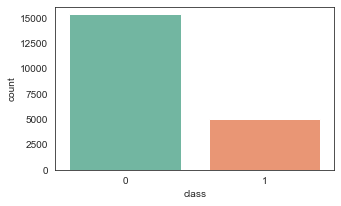

In [19]:
sns.set_style("white")
sns.set_palette('Set2')
fig, ax=plt.subplots(figsize=(5, 3))
ax = sns.countplot(df['class'])
fig.show()

**dataset is imbalanced**

Text(0.5, 1.0, 'Distribution of The Subject According to Real and Fake Data')

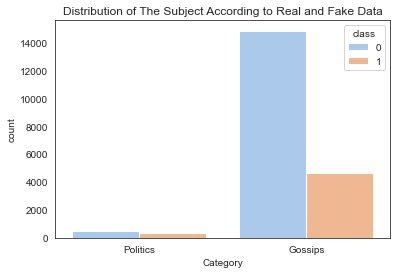

In [20]:
## Distribution of The Subject According to Real and Fake Data
ax = sns.countplot(x="Category",  hue='class', data=df, palette="pastel")
plt.title("Distribution of The Subject According to Real and Fake Data")

In [21]:
import copy
df2=copy.deepcopy(df)

In [22]:
from urllib.parse import urlsplit

In [23]:
def to_key(url):
    if "://" not in url:  
        url = f"https://{url}"
    return urlsplit(url).hostname

In [24]:
df2["url_filter"] = df2['url'].apply(to_key)

#### Visualising the count of real  and fake news count from websites

In [25]:
real_order=df2[df2['class']==0]['url_filter'].value_counts().sort_values(ascending=False).index

In [26]:
df_real=df2.pivot_table(index = 'domain', columns = 'class', values = 'url', aggfunc='count').fillna(0).astype(int).sort_values(0,axis=0,ascending=False).head(15)

<AxesSubplot:xlabel='domain'>

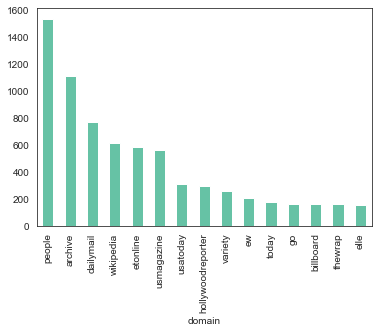

In [27]:
df_real[0].plot(kind='bar')

In [28]:
df_fake=df2.pivot_table(index = 'domain', columns = 'class', values = 'url', aggfunc='count').fillna(0).astype(int).sort_values(1,axis=0,ascending=False).head(15)

<AxesSubplot:xlabel='domain'>

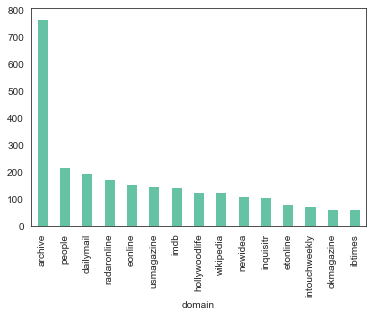

In [29]:
df_fake[1].plot(kind='bar')

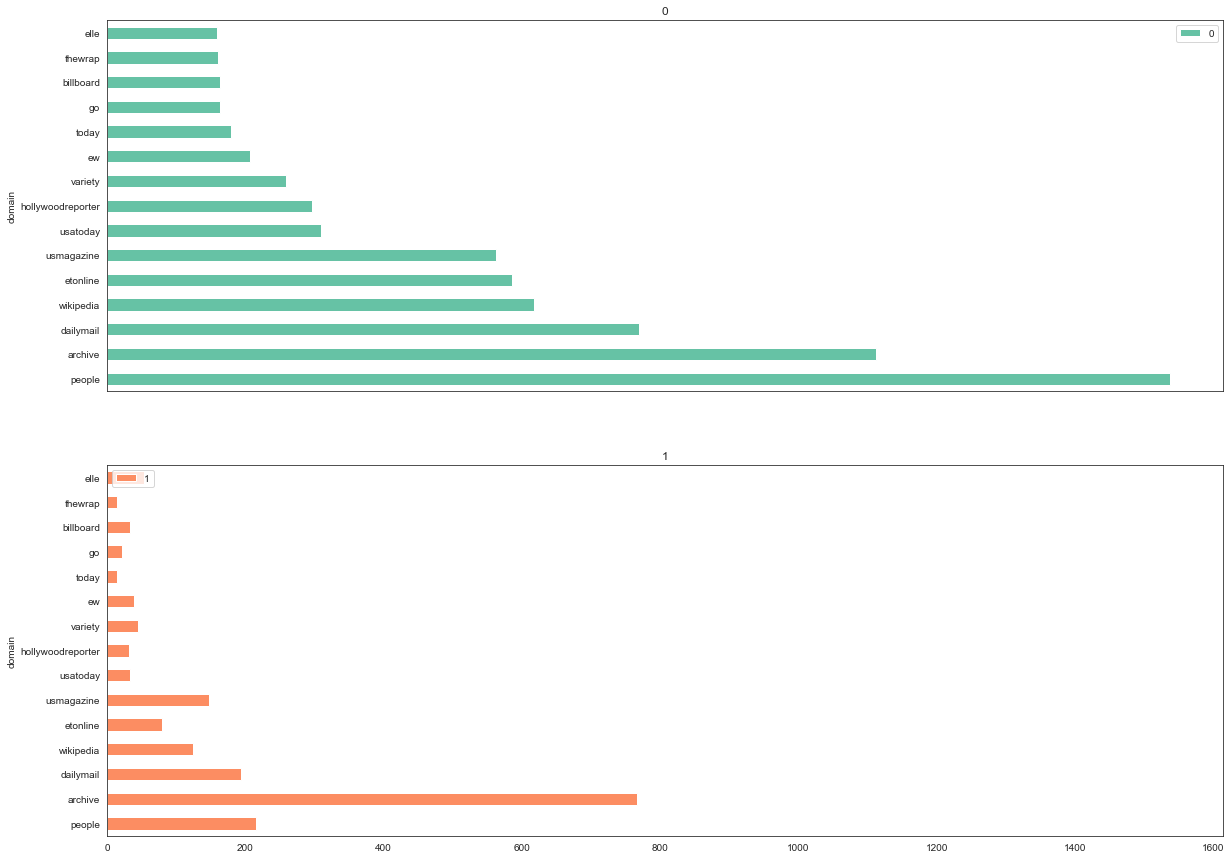

In [30]:
axes = df_real.plot.barh(rot=0, subplots=True, figsize=(20, 15))
axes[1].legend(loc=2) 

#### Common websites for publishing both real  and fake news

<AxesSubplot:xlabel='domain'>

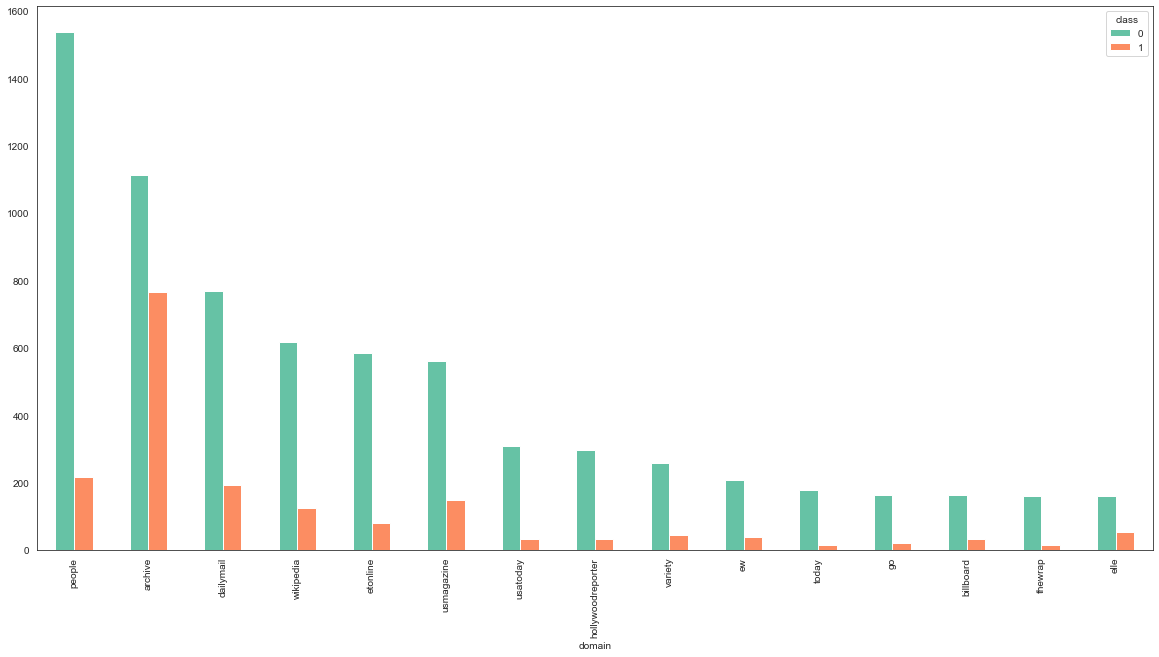

In [31]:
df_real.plot(kind='bar',figsize=(20, 10))

#### Visualising the count of fake news count from websites

In [278]:
#df2[['url','url_filter']].head(200)

In [279]:
#df2=df.pivot_table(index = 'domain', columns = 'class', values = 'url', aggfunc='count').fillna(0).astype(int).sort_values(1,axis=0,ascending=False).head(100)

In [280]:
#df2[1].loc[df2[1]>0].count()

In [281]:
# Groupby by country
#domain = df2[1].loc[df2[1]>0].groupby("domain")

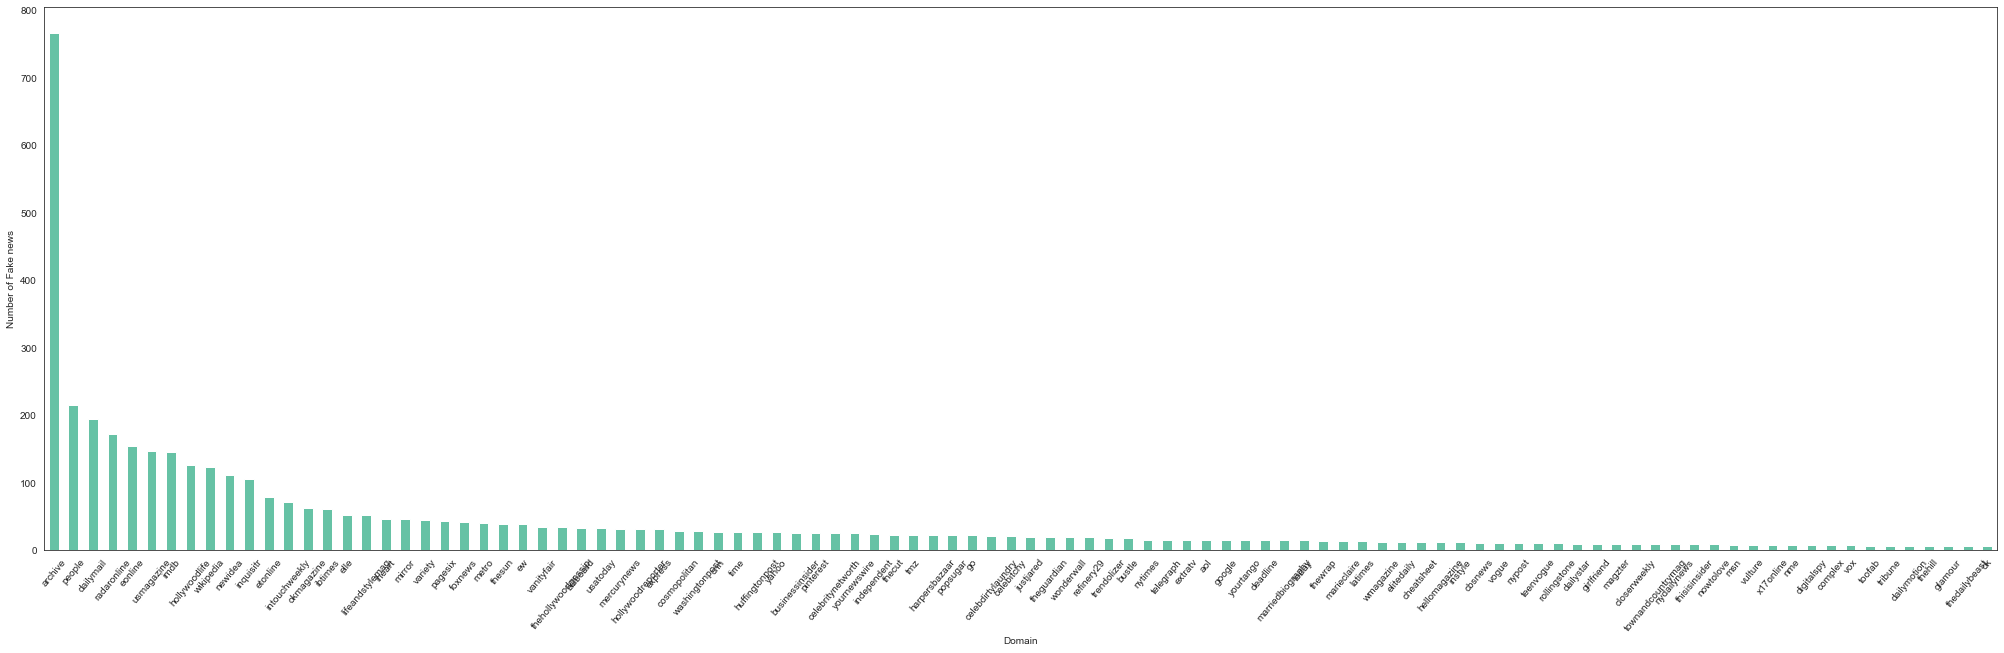

In [56]:
# plt.figure(figsize=(35,10))
# domain.head(1).plot.bar()
# plt.xticks(rotation=50)
# plt.xlabel("Domain")
# plt.ylabel("Number of Fake news")
# plt.show()

In [32]:
#df['title_length']=df['title'].apply(lambda x: len(x))
#df3=copy.deepcopy(df)
df2=df2.dropna()
df2['title_length']  = df2['title'].str.len().astype('int')

#### Title Length Analysis for Real and Fake news

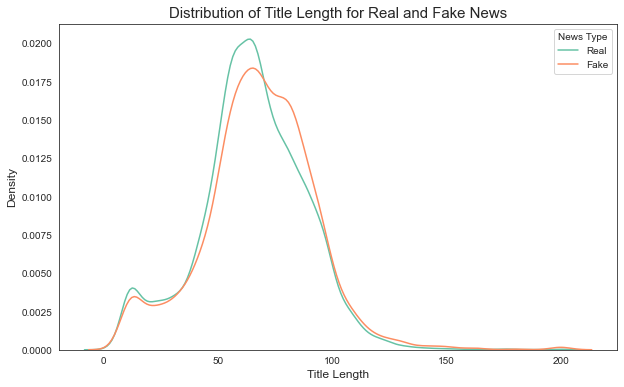

In [33]:
plt.figure(figsize=(10,6))
sns.kdeplot(df2[df2['class']==0]['title_length'])
sns.kdeplot(df2[df2['class']==1]['title_length'])
plt.xlabel('Title Length',fontsize=12)
plt.ylabel('Density',fontsize=12)
plt.legend(title='News Type',fontsize=10,labels=['Real','Fake'])
plt.title('Distribution of Title Length for Real and Fake News',fontsize=15)
plt.show()

The width of the fake news title length plot distribution is slightly larger than that of real news.Most of the fake news articles having title length greater than 100 when compared witht he real news title length

#### News Body Length Analysis for Real and Fake news

In [34]:
df2['body_length']  = df2['text'].str.len().astype('int')

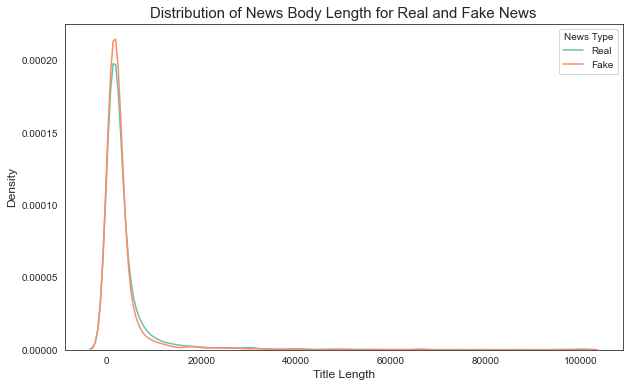

In [35]:
plt.figure(figsize=(10,6))
sns.kdeplot(df2[df2['class']==0]['body_length'])
sns.kdeplot(df2[df2['class']==1]['body_length'])
plt.xlabel('Title Length',fontsize=12)
plt.ylabel('Density',fontsize=12)
plt.legend(title='News Type',fontsize=10,labels=['Real','Fake'])
plt.title('Distribution of News Body Length for Real and Fake News',fontsize=15)
plt.show()

In [38]:
#stop_words_list = ["say", "also", "see","know","make","like","know","take","would","go","get","well","look","could"] + list(STOPWORDS)
#stop_words = STOPWORDS.update(["say", "also", "see","know","make"])

#stopwords.add("based")

### Text PreProcessing

##### combining title and text to full text column

In [36]:
df2.shape

(20275, 11)

In [37]:
df2['fulltext']=df2['title']+'.'+df2['text']
#df2=df2.drop(columns=['url', 'text','title','authors','num_images','domain','Category','url_filter'], axis=1)
df2=df2.dropna()
df2.shape

(20275, 12)

#### checking text cleaning for the first row

In [212]:
first_text = df2.fulltext[1]
#first_text   

#### Remove any HTML Content

In [213]:
bsoup = BeautifulSoup(first_text, "html.parser")
first_text = bsoup.get_text()
#first_text

#### Remove any URL

In [214]:
# def remove_URL(headline_text):
#     url = re.compile(r'https?://\S+|www\.\S+')
#     return url.sub(r'', headline_text)

url = re.compile(r'https?://\S+|www\.\S+')
url.sub(r'', first_text)
#first_text

'Trump on Prejean: Same as ObamaAt a press conference addressing Carrie Prejean’s disputed title in the Miss USA competition, pageant owner Donald Trump compared Prejean’s stated views on gay marriage to Obama’s.\n\n“It’s the same answer that the president of the United States gave,” Trump said. “She gave an honorable answer. She gave an answer from her heart.”\n\nIn her own remarks moments later, Prejean echoed Trump’s statement, telling reporters: “The president of the United States, the secretary of state, and many Americans agree with me in this belief.”\n\nIn the final round of the Miss USA pageant, Prejean told judge Perez Hilton: “I think in my country, in my family, I think that I believe that a marriage should be between a man and a woman. No offense to anybody out there, but that’s how I was raised.”'

##### Removal of any numbers

In [215]:
first_text=re.sub(r'\d+','',first_text)
#first_text

In [216]:
# third_text = df2.fulltext[2]
# third_text=re.sub(r'\d+','',third_text)
# third_text

#### Removal of all kinds of date formats

In [217]:
first_text=re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', first_text)  # 10-03-1987
first_text=re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', first_text)  # 10/03/1987
first_text=re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', first_text)  # 10.03.1987


#### Removal of Punctuation and converting to lowercase

In [218]:
first_text = re.sub('\[[^]]*\]', ' ', first_text)
first_text = re.sub('[^a-zA-Z]',' ',first_text)  # replaces non-alphabets with spaces
first_text = first_text.lower() # Converting from uppercase to lowercase

#### Replacing 2 or more consecutive whitespaces with a single one

In [219]:
first_text=re.sub(r' {2,}',' ',first_text)

#### Stopwords List

In [5]:
len(STOPWORDS)  # Wordcloud

192

In [6]:
len(stopwords.words('english')) # nltk

179

In [7]:
#loading the english language small model of spacy
import spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
len(sw_spacy)

326

In [8]:
gensim_stopwords_list=list(gensim_stopwords) # gensim
nltk_stopwords_list=stopwords.words('english') # nltk
spacy_stopwords=list(sw_spacy) # spacy
wordcloud_stopwords_list=list(STOPWORDS)

In [9]:
total_stop_words_list= set(gensim_stopwords_list + nltk_stopwords_list + spacy_stopwords + wordcloud_stopwords_list)

In [10]:
#total_stop_words_list

In [11]:
len(total_stop_words_list)

448

#### Removal of Stopwords

In [226]:
#total_stop_words_list

In [227]:
#stop_words_list = ["say", "also", "see","know","make","like","know","take","would","go","get","well","look","could"] + list(STOPWORDS)
#stop_words = STOPWORDS.update(["say", "also", "see","know","make"])


In [244]:
word_tokens = word_tokenize(first_text) 
stop_words = set(stopwords.words('english'))

newlist = [w.strip() for w in word_tokens if w not in total_stop_words_list and len(w) > 2] 

#### Lemmitization and Stemming

In [245]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag,wordnet.NOUN)

porter = PorterStemmer()
lancaster=LancasterStemmer()
lemmatizer = WordNetLemmatizer()

In [247]:
# Stemming
#newlist=[porter.stem(w) for w in newlist]  

In [248]:
# Lancaster Stemmer 
#newlist= [lancaster.stem(w) for w in newlist]

In [246]:
# WordNet Lemmatizer
newlist= [lemmatizer.lemmatize(w,get_wordnet_pos(w)) for w in newlist]

In [247]:
newlist = sorted(set(newlist), key=lambda x:newlist.index(x))    ## Removing duplicates

In [248]:
print(type(newlist))

<class 'list'>


In [250]:
### Again applying the removal of stop words
newlist2 = [w.strip() for w in newlist if w not in total_stop_words_list and len(w) > 2] 

In [251]:
#newlist2

['trump',
 'prejean',
 'obamaat',
 'press',
 'conference',
 'address',
 'carrie',
 'dispute',
 'title',
 'miss',
 'usa',
 'competition',
 'pageant',
 'owner',
 'donald',
 'compare',
 'state',
 'view',
 'gay',
 'marriage',
 'obama',
 'answer',
 'president',
 'united',
 'honorable',
 'heart',
 'remark',
 'moment',
 'later',
 'echoed',
 'statement',
 'tell',
 'reporter',
 'secretary',
 'american',
 'agree',
 'belief',
 'final',
 'round',
 'told',
 'judge',
 'perez',
 'hilton',
 'think',
 'country',
 'family',
 'believe',
 'man',
 'woman',
 'offense',
 'anybody',
 'raise']

#### Helper Function to preprocess the text  with all the operations as mentioned above

In [252]:
def text_preprocess(text):

    # Remove HTML tags
    bsoup = BeautifulSoup(text, "html.parser")
    clean_text = bsoup.get_text()
    
    
    # Remove any URL
    url = re.compile(r'https?://\S+|www\.\S+')
    url.sub(r'', clean_text)
    
    # Remove any numbers
    clean_text=re.sub(r'\d+','',clean_text)
    
    # Remove all kinds of date formats
    clean_text=re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', clean_text)
    clean_text=re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', clean_text)
    clean_text=re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', clean_text)
    
    
    # Removal of punctuation and lower case conversion
    clean_text = re.sub('\[[^]]*\]', ' ', clean_text)
    clean_text = re.sub('[^a-zA-Z]',' ',clean_text)  # replaces non-alphabets with spaces
    clean_text = clean_text.lower()
    
    # Removal of 2 consecutive double space
    clean_text=re.sub(r' {2,}',' ',clean_text)
    
    # Removal of stop words
    word_tokens = word_tokenize(clean_text) 
    #stop_words = set(stopwords.words('english'))

    newcleantext = [w.strip() for w in word_tokens if w not in total_stop_words_list and len(w) > 2] 
    
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    newcleantext= [lemmatizer.lemmatize(w,get_wordnet_pos(w)) for w in newcleantext]
    
    ### Again applying the removal of stop words
     
    newcleantext = [w.strip() for w in newcleantext if w not in total_stop_words_list and len(w) > 2] 
    
    ## Removing duplicates
    newcleantext = sorted(set(newcleantext), key=lambda x:newcleantext.index(x))
    
    return newcleantext

In [5]:
import time

# get the start time
st = time.time()


#Apply function on text column
df2['cleaned_fulltext']=df2['fulltext'].apply(text_preprocess)
#df2['cleaned_fulltext'] = df2['cleaned_fulltext'].apply(lambda x: x[1:-1])
# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

NameError: name 'df2' is not defined

#### Saved cleaned dataframe to a csv

In [255]:
df2.to_csv('df2_Cleanedfulltext1.csv', index=False)

#### Loading the cleaned dataset from CSV

In [12]:
df3 = pd.read_csv("df2_Cleanedfulltext1.csv")

#### Word Count Analysis for Fake News

In [13]:
df3['cleaned_fulltext'] = df3['cleaned_fulltext'].apply(lambda x: x[0:-1])

#### Word Count Analysis for Fake News

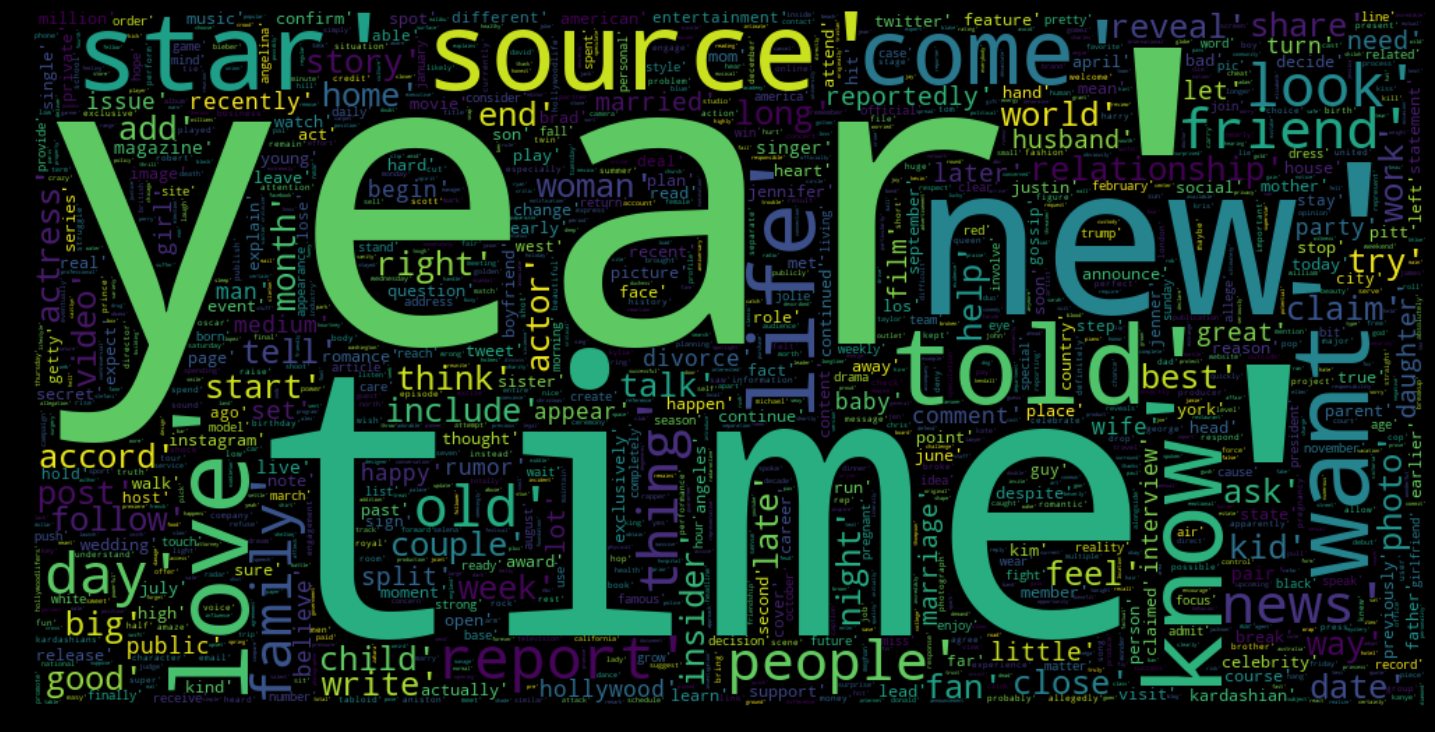

In [12]:
#from wordcloud import WordCloud,STOPWORDS

wc = WordCloud(max_words = 2000 , width = 1000 , height = 500 , background_color = 'black',stopwords = total_stop_words_list,collocations=False).generate(" ".join(df3[df3['class']== 1].cleaned_fulltext))
fig = plt.figure(
    figsize = (25, 15),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('on')
plt.show()

#### Word Count Analysis for Real News

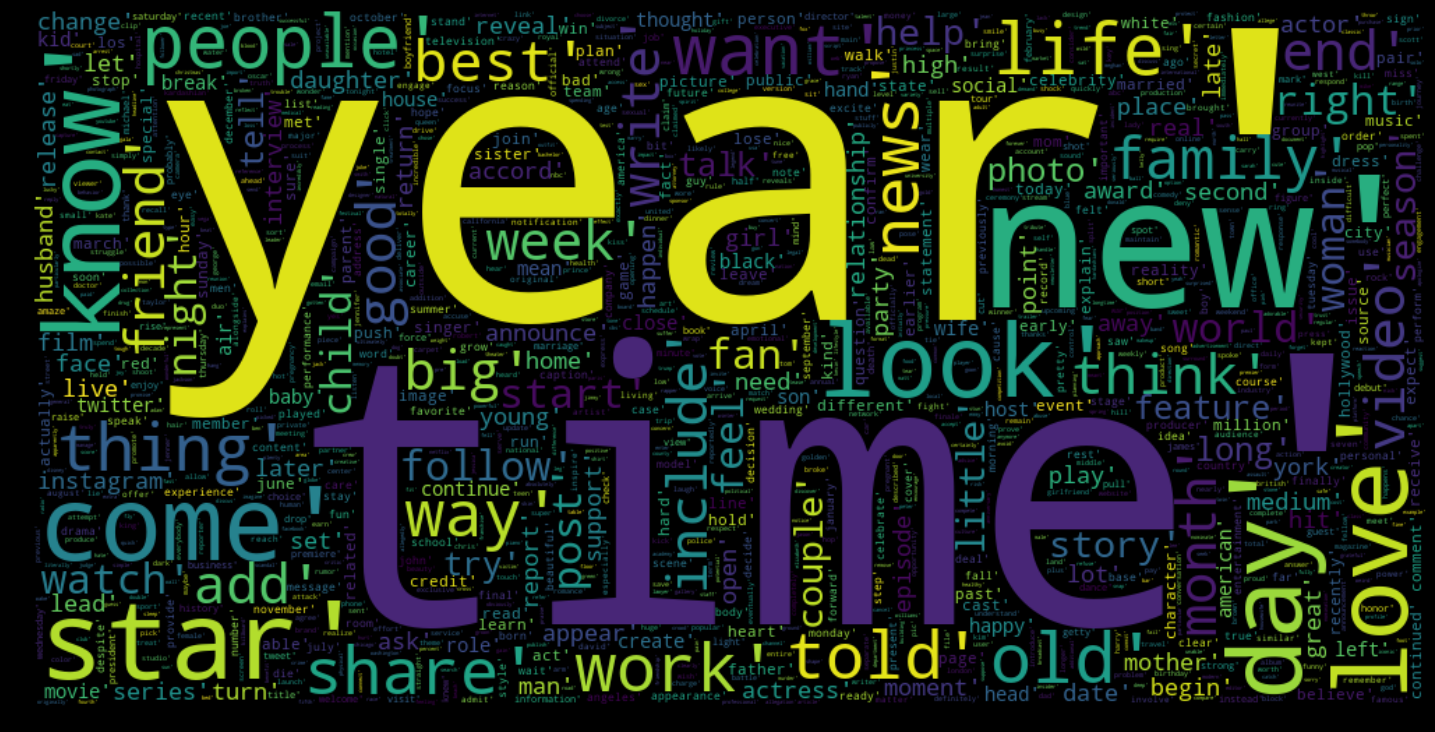

In [13]:
wc = WordCloud(max_words = 2000 , width = 1000 , height = 500 , background_color = 'black',stopwords = total_stop_words_list,collocations=False).generate(" ".join(df3[df3['class']== 0].cleaned_fulltext).lower())
#plt.imshow(wc , interpolation = 'bilinear')
fig = plt.figure(
    figsize = (25, 15),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('on')
plt.show()

#### Frequency Count Distribution  for both Fake and Real news

In [17]:
from collections import Counter
from itertools import chain

In [20]:
def frequency_words(words, classnm):
    counter = Counter(chain.from_iterable(words))
    df_freq_word = pd.DataFrame(counter.values(), index = counter.keys(), columns = ['Word_Frequency'])
    df_freq_word.index = df_freq_word.index.set_names(classnm)
    df_freq_word = df_freq_word.sort_values(by = 'Word_Frequency', ascending = False, axis=0)[:30]
    df_freq_word = df_freq_word.pivot_table(columns = classnm)
    df_freq_word = df_freq_word.sort_values(by = 'Word_Frequency', ascending = False, axis=1)
    display(df_freq_word)
    
words_fake = [s.split() for s in df3.loc[df3['class'] == 1]['cleaned_fulltext']]
words_real = [s.split() for s in df3.loc[df3['class'] == 0]['cleaned_fulltext']]
frequency_words(words_fake, 'Fake')
frequency_words(words_real, 'Real')

Fake,"'year',","'time',","'new',","'source',","'star',","'told',","'want',","'know',","'love',","'come',","'life',","'report',","'look',","'old',","'day',","'thing',","'people',","'news',","'family',","'friend',","'relationship',","'think',","'add',","'work',","'couple',","'way',","'tell',","'accord',","'month',","'share',"
Word_Frequency,2911,2787,2352,2097,2063,2047,1991,1949,1936,1884,1864,1852,1766,1707,1686,1630,1625,1621,1597,1586,1565,1537,1498,1492,1476,1457,1407,1384,1368,1350


Real,"'year',","'time',","'new',","'star',","'know',","'come',","'day',","'look',","'love',","'people',","'life',","'want',","'old',","'work',","'news',","'share',","'told',","'thing',","'way',","'family',","'best',","'include',","'think',","'video',","'friend',","'big',","'week',","'good',","'write',","'month',"
Word_Frequency,8825,8216,7165,6755,6071,5941,5806,5796,5717,5635,5311,5306,5126,4764,4760,4663,4644,4618,4509,4429,4315,4158,4128,3985,3949,3924,3850,3827,3801,3786


### Count of Words for each row text

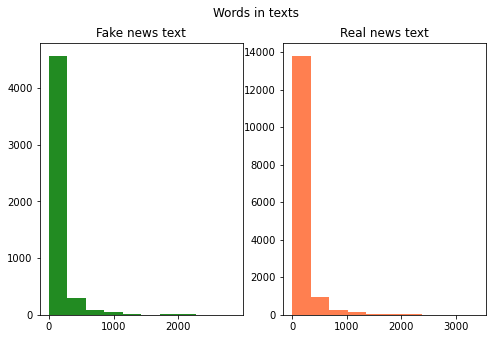

In [21]:
#https://matplotlib.org/3.5.0/gallery/color/named_colors.html
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(8,5))
text_len=df3[df3['class']==1]['cleaned_fulltext'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='forestgreen')
ax1.set_title('Fake news text')
text_len=df3[df3['class']==0]['cleaned_fulltext'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='coral')
ax2.set_title('Real news text')
fig.suptitle('Words in texts')
plt.show()

Around 500 words are common words present in both real and fake news categories

### Analysis of n-gram  for fake and real news articles

In [22]:
# def clean_format(text):
#     clean_text=re.sub('\[[^]]*\]', ' ', text)
#     clean_text = re.sub('[^a-zA-Z]',' ',clean_text)  # replaces non-alphabets with spaces
#     clean_text=re.sub(r' {2,}',' ',clean_text)
#     clean_text = clean_text.strip(" ").split(" ")
#     return clean_text

In [23]:
real_texts=' '.join(df3.loc[df3['class'] == 0]['cleaned_fulltext'])

In [24]:
fake_texts=' '.join(df3.loc[df3['class'] == 1]['cleaned_fulltext'])

In [25]:
fake_texts = re.sub('\[[^]]*\]', ' ', fake_texts)
fake_texts = re.sub('[^a-zA-Z]',' ',fake_texts)  # replaces non-alphabets with spaces
fake_texts=re.sub(r' {2,}',' ',fake_texts)

real_texts = re.sub('\[[^]]*\]', ' ', real_texts)
real_texts = re.sub('[^a-zA-Z]',' ',real_texts)
real_texts=re.sub(r' {2,}',' ',real_texts)


fake_string = fake_texts.strip(" ").split(" ")
real_string = real_texts.strip(" ").split(" ")

In [26]:
def plot_n_gram(string,i):
    n_gram = (pd.Series(nltk.ngrams(string, i)).value_counts())[:15]
    n_gram_df=pd.DataFrame(n_gram)
    n_gram_df = n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    print(n_gram_df.head())
    plt.figure(figsize = (16,9))
    return sns.barplot(x='count',y='word', data=n_gram_df)

#### Unigram Analysis

      word  count
0  (year,)   8857
1  (time,)   8423
2   (new,)   7189
3  (star,)   6778
4  (know,)   6111


<AxesSubplot:xlabel='count', ylabel='word'>

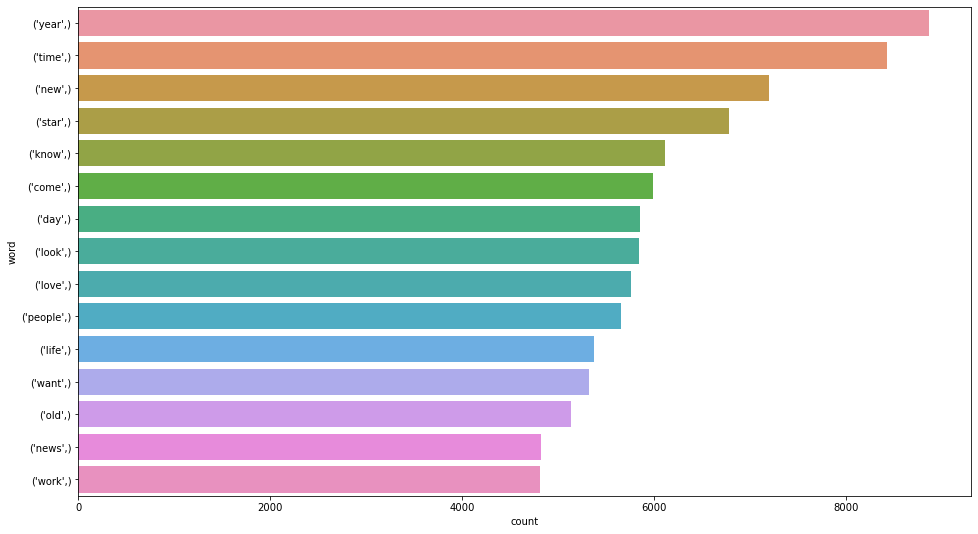

In [27]:
plot_n_gram(real_string,1)

        word  count
0    (year,)   2920
1    (time,)   2824
2     (new,)   2353
3  (source,)   2112
4    (star,)   2071


<AxesSubplot:xlabel='count', ylabel='word'>

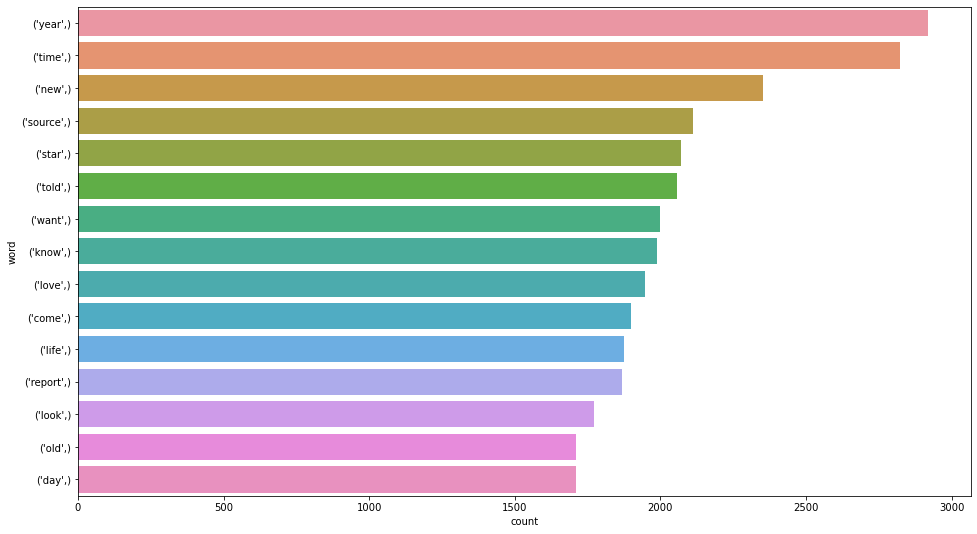

In [28]:
plot_n_gram(fake_string,1)

#### Bigram Analysis

                   word  count
0           (year, old)   2764
1        (los, angeles)   1644
2      (social, medium)   1569
3           (new, york)   1532
4  (push, notification)   1185


<AxesSubplot:xlabel='count', ylabel='word'>

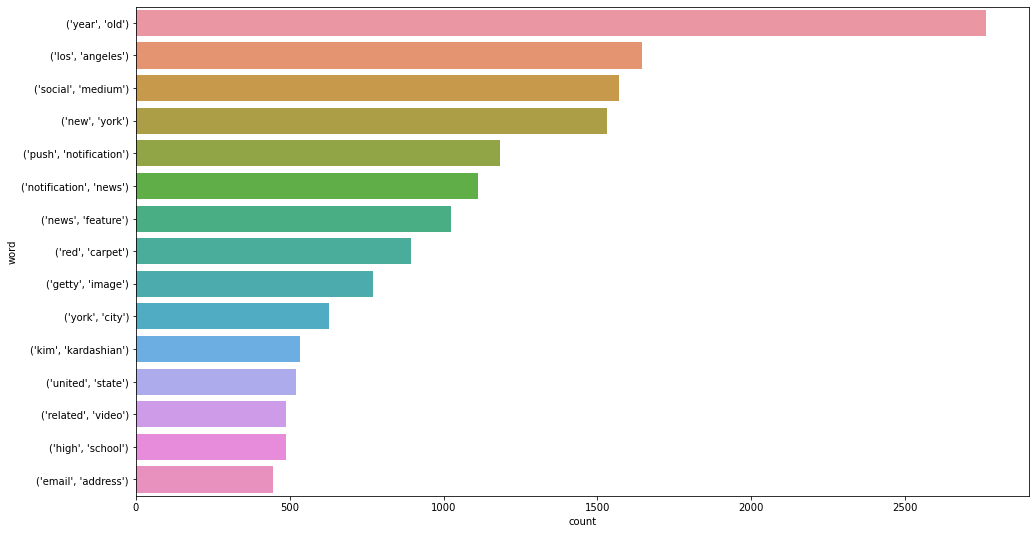

In [29]:
plot_n_gram(real_string,2)

               word  count
0       (year, old)    879
1    (los, angeles)    562
2       (new, york)    467
3      (brad, pitt)    461
4  (social, medium)    421


<AxesSubplot:xlabel='count', ylabel='word'>

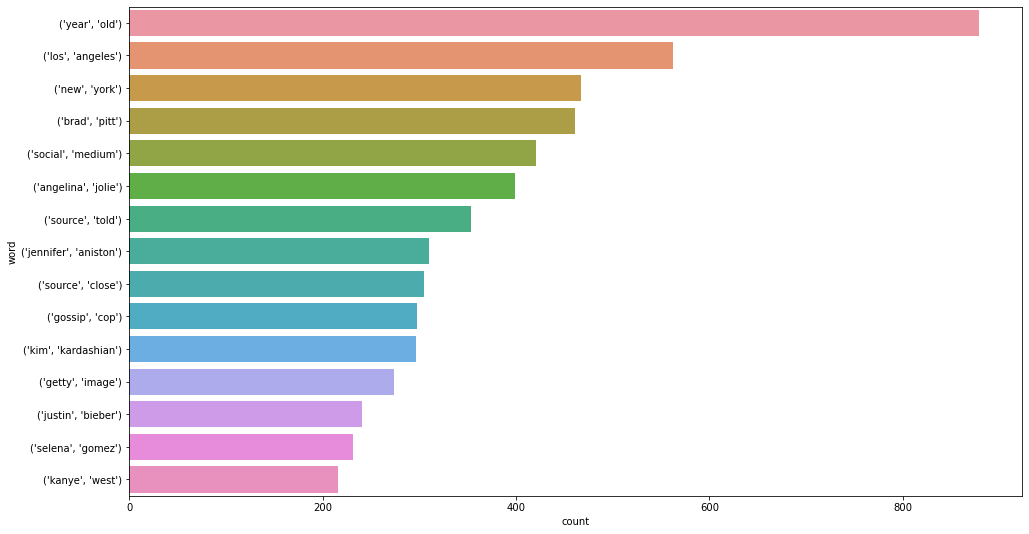

In [30]:
plot_n_gram(fake_string,2)

#### Trigram Analysis

                            word  count
0     (push, notification, news)   1107
1  (notification, news, feature)   1012
2              (new, york, city)    452
3    (software, disable, reload)    408
4     (block, software, disable)    404


<AxesSubplot:xlabel='count', ylabel='word'>

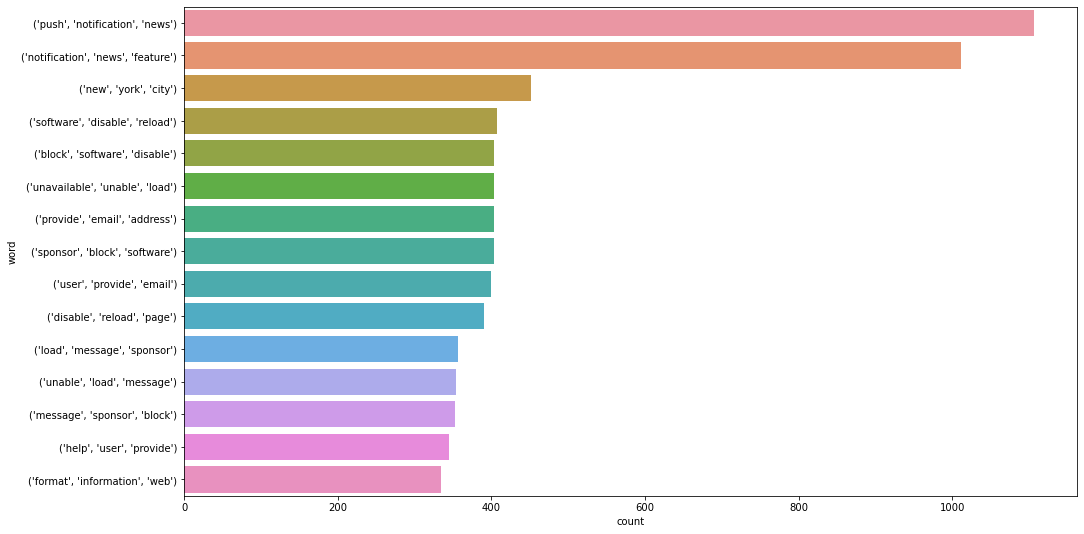

In [31]:
plot_n_gram(real_string,3)

                                  word  count
0           (push, notification, news)    170
1        (notification, news, feature)    151
2     (entertainment, user, represent)    127
3      (opinion, guarantee, reporting)    127
4  (responsibility, content, accuracy)    127


<AxesSubplot:xlabel='count', ylabel='word'>

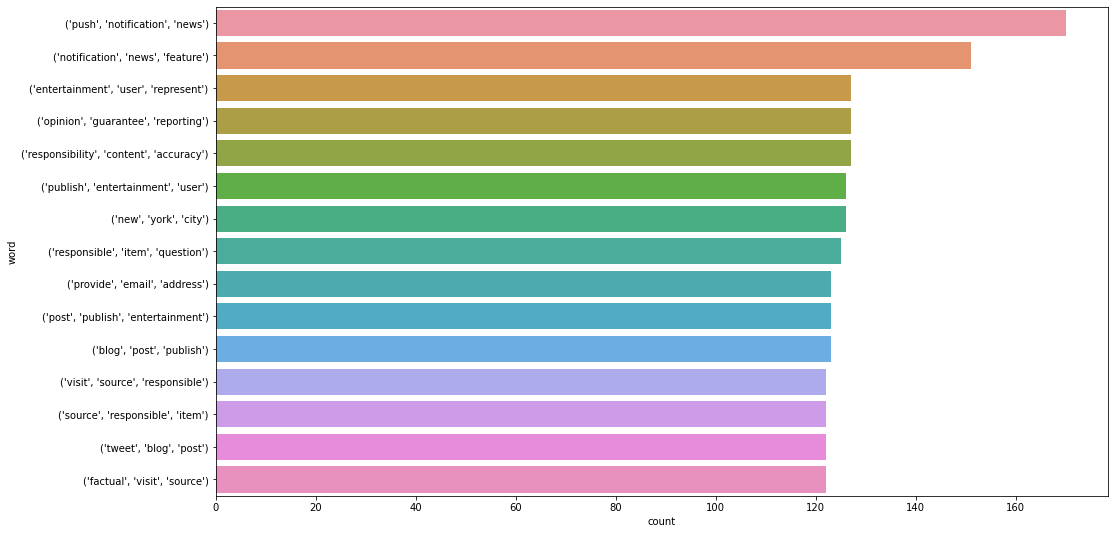

In [32]:
plot_n_gram(fake_string,3)

In [33]:
#df3.head(2)

#### Identify truth percentage probability for each domain 

In [14]:
df_truth = pd.pivot_table(df3,index='domain',columns='class',fill_value=0,aggfunc={'domain':'count'})
df_truth['%truth'] = df_truth.apply(lambda row: row[0]/(row[0]+row[1]),axis=1)
df_truth[(df_truth['%truth']!=0)&(df_truth['%truth']!=1)].sort_values(by='%truth',ascending=False)

domain         %truth
class                      0    1          
domain                                     
tvline                    71    1  0.986111
medium                   103    2  0.980952
scoopnest                 49    1  0.980000
upi                       67    2  0.971014
indiewire                 30    1  0.967742
stylecaster               29    1  0.966667
bravotv                  137    6  0.958042
popculture                74    4  0.948718
hellogiggles              73    4  0.948052
bbc                       69    4  0.945205
tvinsider                 17    1  0.944444
msn                       17    1  0.944444
essence                   16    1  0.941176
hola                      15    1  0.937500
reuters                   15    1  0.937500
glamour                   87    7  0.925532
politifact                24    2  0.923077
tennessean                12    1  0.923077
justjaredjr               12    1  0.923077
tvguide                   24    2  0.923077
newslocker                12    1  0.923077
blogspot                  24    2  0.923077
today                    179   15  0.922680
thewrap                  160   14  0.919540
esquire                   11    1  0.916667
cmt                       11    1  0.916667
realityblurb              11    1  0.916667
theverge                  22    2  0.916667
chicagotribune            21    2  0.913043
allure                    30    3  0.909091
popcrush                  10    1  0.909091
deadline                 144   15  0.905660
instyle                  114   12  0.904762
usatoday                 310   33  0.903790
hollywoodreporter        297   32  0.902736
womenshealthmag            9    1  0.900000
reddit                    27    3  0.900000
npr                       18    2  0.900000
brit                      27    3  0.900000
countryliving             17    2  0.894737
wordpress                 33    4  0.891892
fortune                   16    2  0.888889
fame10                     8    1  0.888889
seventeen                 32    4  0.888889
vulture                   64    8  0.888889
amazon                    40    5  0.888889
nbcnews                   39    5  0.886364
biography                 31    4  0.885714
toofab                    54    7  0.885246
go                       164   22  0.881720
etonline                 585   79  0.881024
bustle                   130   18  0.878378
people                  1537  216  0.876783
christianpost             28    4  0.875000
allabouttrh                7    1  0.875000
pressparty                 7    1  0.875000
cbslocal                   7    1  0.875000
cnbc                      14    2  0.875000
nytimes                  107   16  0.869919
globalnews                20    3  0.869565
rollingstone              73   11  0.869048
theblast                  13    2  0.866667
ajc                       19    3  0.863636
quora                     24    4  0.857143
screencrush                6    1  0.857143
mtv                       18    3  0.857143
etcanada                  18    3  0.857143
harpersbazaar            136   23  0.855346
brides                    35    6  0.853659
variety                  259   45  0.851974
glamourmagazine           17    3  0.850000
time                     153   27  0.850000
nickiswift                22    4  0.846154
gq                        11    2  0.846154
her                       11    2  0.846154
refinery29               104   19  0.845528
ew                       207   39  0.841463
thisisinsider             47    9  0.839286
nydailynews               47    9  0.839286
architecturaldigest       10    2  0.833333
usnews                     5    1  0.833333
inverse                    5    1  0.833333
cbsnews                   55   11  0.833333
bleacherreport             5    1  0.833333
dnaindia                   5    1  0.833333
adweek                     5    1  0.833333
xxlmag                     5    1  0.833333
womansday                  5    1  0.833333
cinemablend       

The domains **"tvline," "medium," "bravotv," "today,"** and **"thewrap"** are among the most prominent online websites that publish a significant amount of genuine news. Meanwhile, the domain named **'archive'** publishes both real and fake news equally often.
Also , the domain sites such as **'hollywoodlife','radaronline'** and **'newidea'** are the main sites publishing more false news

In [14]:
import copy

In [15]:
df4=copy.deepcopy(df3)

In [16]:
def clean_format(text):
    clean_text=re.sub('\[[^]]*\]', ' ', text)
    clean_text = re.sub('[^a-zA-Z]',' ',clean_text)  # replaces non-alphabets with spaces
    clean_text=re.sub(r' {2,}',' ',clean_text)
    return clean_text

In [17]:
df4['cleaned_fulltext']=df4['cleaned_fulltext'].apply(clean_format)

In [19]:
## Shuffling the rows
df4 = df4.sample(frac=1).reset_index(drop=True)

In [20]:
df4.reset_index(drop=True,inplace=True)

## Model Building

#### Splitting Data into Train and Test Datasets

In [21]:
X=df4['cleaned_fulltext']
y=df4['class']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=0)

#### Creating Pipeline using  TF-IDF Vectorizer using one gram

In [23]:
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [24]:
X_train_tfidf.shape

(16220, 89359)

In [25]:
# tfidf = TfidfVectorizer(ngram_range=(2,2))
# X_train_tfidf = tfidf.fit_transform(X_train)
# X_test_tfidf = tfidf.transform(X_test)

In [26]:
# X_train_tfidf.shape

### Helper Functions

In [27]:
import timeit
from timeit import default_timer as timer
from datetime import timedelta
 


def metrics(X_test,y_test,clf):
    predictions=clf.predict(X_test)
    #predictions=(clf.predict_proba(X_test)[:,1] >= 0.3).astype(bool)
    print("confusion_matrix :")
    print(confusion_matrix(y_test,predictions))
    print("Accuracy Score :")
    print(accuracy_score(y_test, predictions))
    print("Classification Report :")
    print(classification_report(y_test, predictions))
    print("F1 score :")
    print(f1_score(y_test, predictions))
    print("ROC AUC Score")
    y_pred_proba = clf.predict_proba(X_test)
    print(roc_auc_score(y_test, y_pred_proba[:,1]) )
    print("------------------------------")

    
def model_comparison_table(X_test,y_test,classifier_list):
    dict_clf={}
    for clf_name,clf in classifier_list:
        predictions=clf.predict(X_test)
        y_pred_proba = clf.predict_proba(X_test)
        accuracy=accuracy_score(y_test, predictions)
        precision=precision_score(y_test,predictions,average='macro').round(2)
        recall=recall_score(y_test,predictions)
        f1score=f1_score(y_test,predictions).round(2)
        ROC_AUC=roc_auc_score(y_test, y_pred_proba[:,1])
        dict_clf[clf_name]=[accuracy,precision,recall,f1score,ROC_AUC]
    df_models_scores = pd.DataFrame(dict_clf, index=['Accuracy', 'Precision', 'Recall', 'F1 Score','roc_auc_score'])
    return df_models_scores

## Random Forest

In [24]:
rf_clf=RandomForestClassifier(random_state=0)

In [25]:
rf_clf.fit(X_train_tfidf,y_train)

pred = rf_clf.predict(X_test_tfidf)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))

Accuracy score : 0.8414303329223182
Confusion matrix : 
 [[2989   59]
 [ 584  423]]


In [26]:
print("Classification Report")
print(classification_report(y_test, pred))

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.98      0.90      3048
           1       0.88      0.42      0.57      1007

    accuracy                           0.84      4055
   macro avg       0.86      0.70      0.74      4055
weighted avg       0.85      0.84      0.82      4055



##### Hyperparameter Tuning

In [32]:
# Number of trees in random forest
n_estimators =[int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth =[int(x) for x in np.linspace(10, 110, num = 11)]
#Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {
    'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap
              }
pprint(random_grid)



{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}


In [33]:
rf_clf1=RandomForestClassifier(random_state=0)

In [34]:
rf_random = RandomizedSearchCV(estimator=rf_clf1, param_distributions=random_grid,
                              n_iter = 100, 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)


# Fit the random search model
rf_random.fit(X_train_tfidf,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  30.5s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=700; total time= 1.4min
[CV] END bootstrap=True, max_depth=20, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=  13.3s
[CV] END bootstrap=False, max_depth=70, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 3.7min
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time= 2.0min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=  23.4s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=80

[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=400; total time= 4.6min
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=900; total time=  35.3s
[CV] END bootstrap=True, max_depth=60, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 2.9min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000; total time= 3.1min
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 4.2min
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=900; total time= 4.6min
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time= 1.4min
[CV] END bootstrap=False, max_depth=20,

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time=  30.8s
[CV] END bootstrap=False, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=700; total time= 1.4min
[CV] END bootstrap=False, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=800; total time= 4.0min
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=1000; total time=  44.0s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=600; total time= 2.2min
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=900; total time= 2.5min
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time= 1.2min
[CV] END bootstrap=False, max_depth=90

[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time=  35.4s
[CV] END bootstrap=True, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 3.7min
[CV] END bootstrap=False, max_depth=110, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=1000; total time= 7.8min
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=1000; total time= 4.8min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time= 1.2min
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=900; total time= 3.7min
[CV] END bootstrap=True, max_depth=80, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time= 2.2min
[CV] END bootstrap=False, max_depth=70

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, return_train_score=True, verbose=2)

In [35]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 110,
 'bootstrap': False}

[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  28.4s
[CV] END bootstrap=False, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=  18.7s
[CV] END bootstrap=True, max_depth=110, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=500; total time= 1.5min
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=  46.3s
[CV] END bootstrap=False, max_depth=20, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=900; total time= 1.6min
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=900; total time= 1.2min
[CV] END bootstrap=True, max_depth=100, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=600; total time= 1.9min
[CV] END bootstrap=False, max_depth=10, m

#### Using with Best Params 

In [28]:
rf_clf_tuned=RandomForestClassifier(random_state=0,n_estimators=800,max_features='auto',max_depth=150,min_samples_split=10,min_samples_leaf=1,bootstrap=False)

rf_clf_tuned.fit(X_train_tfidf,y_train)

pred1 = rf_clf_tuned.predict(X_test_tfidf)
print("Accuracy score : {}".format(accuracy_score(y_test, pred1)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred1)))

Accuracy score : 0.8431565967940814
Confusion matrix : 
 [[3000   48]
 [ 588  419]]


In [29]:
print("F1 score :")
print(f1_score(y_test, pred1))
print("Classification Report")
print(classification_report(y_test, pred1))

F1 score :
0.5685210312075983
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.98      0.90      3048
           1       0.90      0.42      0.57      1007

    accuracy                           0.84      4055
   macro avg       0.87      0.70      0.74      4055
weighted avg       0.85      0.84      0.82      4055



### Best Parameters for Random Forest 

**rf_clf1=RandomForestClassifier(random_state=0,n_estimators=800,max_features='auto',max_depth=150,min_samples_split=10,min_samples_leaf=1,bootstrap=False)**

### Accuracy  got 84%

In [ ]:

# classifiers = [('Logistic Regression',log_mdl), ( 'Decision Tree', dt_mdl),( 'SVM', svc_mdl),
#                ('Random Forest',rf_mdl),('XgBoost',xg_mdl),('Naive Bayes',nb_mdl),('KNN',knn_mdl)]

In [30]:
classifiers = [('Random Forest',rf_clf_tuned)]

In [31]:
df_model_scores=model_comparison_table(X_test_tfidf,y_test,classifiers)
df_model_scores.head(20).T

,Accuracy,Precision,Recall,F1 Score,roc_auc_score
Random Forest,0.843157,0.87,0.416087,0.57,0.859713


### Support Vector Machine

In [29]:
svm_clf=SVC(random_state=0)

In [30]:
svm_clf.fit(X_train_tfidf,y_train)

pred = svm_clf.predict(X_test_tfidf)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))

Accuracy score : 0.8611590628853267
Confusion matrix : 
 [[2974   74]
 [ 489  518]]
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.98      0.91      3048
           1       0.88      0.51      0.65      1007

    accuracy                           0.86      4055
   macro avg       0.87      0.75      0.78      4055
weighted avg       0.86      0.86      0.85      4055



#### Hyperparameter Tuning

In [47]:
# Create the random grid
random_grid = {
    'C': [0.1, 1, 10, 100, 1000],
               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
               'kernel':  ['rbf', 'poly', 'sigmoid'],
              }
pprint(random_grid)


{'C': [0.1, 1, 10, 100, 1000],
 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
 'kernel': ['rbf', 'poly', 'sigmoid']}


In [48]:

svm_clf1=SVC(random_state=0)

rf_random = RandomizedSearchCV(estimator=svm_clf1, param_distributions=random_grid,
                              n_iter = 100, 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)


# Fit the random search model
rf_random.fit(X_train_tfidf,y_train)

Fitting 3 folds for each of 75 candidates, totalling 225 fits
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time= 7.0min
[CV] END .................C=10, gamma=0.0001, kernel=sigmoid; total time= 2.0min
[CV] END ....................C=100, gamma=0.0001, kernel=rbf; total time= 2.2min
[CV] END ....................C=1000, gamma=0.01, kernel=poly; total time= 2.0min
[CV] END .....................C=0.1, gamma=0.01, kernel=poly; total time= 1.9min
[CV] END .........................C=1, gamma=0.1, kernel=rbf; total time= 2.3min
[CV] END .....................C=10, gamma=0.001, kernel=poly; total time= 1.9min
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time= 1.7min
[CV] END .................C=100, gamma=0.001, kernel=sigmoid; total time= 2.3min
[CV] END ....................C=1000, gamma=0.01, kernel=poly; total time= 2.0min
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time= 2.0min
[CV] END .......................C=1, gamma=0.01

[CV] END ....................C=0.1, gamma=0.001, kernel=poly; total time= 1.9min
[CV] END ..........................C=1, gamma=1, kernel=poly; total time= 8.3min
[CV] END ................C=100, gamma=0.0001, kernel=sigmoid; total time= 2.2min
[CV] END ...................C=1000, gamma=0.0001, kernel=rbf; total time= 2.2min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 4.4min
[CV] END .........................C=10, gamma=1, kernel=poly; total time= 9.7min
[CV] END ..................C=1000, gamma=0.0001, kernel=poly; total time= 1.9min
[CV] END ................C=0.1, gamma=0.0001, kernel=sigmoid; total time= 2.0min
[CV] END .......................C=1, gamma=0.01, kernel=poly; total time= 1.9min
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time= 7.5min
[CV] END ..................C=1000, gamma=0.1, kernel=sigmoid; total time= 4.3min
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time= 4.3min
[CV] END ...................

[CV] END ....................C=0.1, gamma=0.0001, kernel=rbf; total time= 2.0min
[CV] END ........................C=1, gamma=0.01, kernel=rbf; total time= 2.3min
[CV] END ..................C=10, gamma=0.001, kernel=sigmoid; total time= 2.2min
[CV] END ......................C=100, gamma=0.01, kernel=rbf; total time= 2.4min
[CV] END .....................C=1000, gamma=0.1, kernel=poly; total time= 8.1min
[CV] END ...................C=0.1, gamma=0.0001, kernel=poly; total time= 1.9min
[CV] END ........................C=1, gamma=0.1, kernel=poly; total time= 2.0min
[CV] END ........................C=10, gamma=0.1, kernel=rbf; total time= 2.6min
[CV] END .....................C=100, gamma=0.001, kernel=rbf; total time= 2.2min
[CV] END .......................C=1000, gamma=1, kernel=poly; total time= 9.3min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 2.3min
[CV] END .....................C=1, gamma=0.0001, kernel=poly; total time= 1.9min
[CV] END ...................

RandomizedSearchCV(cv=3, estimator=SVC(random_state=0), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf', 'poly', 'sigmoid']},
                   random_state=42, return_train_score=True, verbose=2)

In [49]:
rf_random.best_params_

{'kernel': 'rbf', 'gamma': 1, 'C': 10}

In [32]:
svm_clf_tuned=SVC(random_state=0,kernel='rbf',gamma=1,C=10,probability=True)
svm_clf_tuned.fit(X_train_tfidf,y_train)

pred1 = svm_clf_tuned.predict(X_test_tfidf)
print("Accuracy score : {}".format(accuracy_score(y_test, pred1)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred1)))

Accuracy score : 0.8658446362515413
Confusion matrix : 
 [[2926  122]
 [ 422  585]]


In [33]:
print("F1 score :")
print(f1_score(y_test, pred1))
print("Classification Report")
print(classification_report(y_test, pred1))

F1 score :
0.6826137689614936
Classification Report
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      3048
           1       0.83      0.58      0.68      1007

    accuracy                           0.87      4055
   macro avg       0.85      0.77      0.80      4055
weighted avg       0.86      0.87      0.86      4055



### Best Parameters for SVM

**svm_clf1=SVC(random_state=0,kernel='rbf',gamma=1,C=10)**

### Accuracy  got 87%

In [34]:
classifiers = [('SVM',svm_clf_tuned)]

In [35]:
df_model_scores=model_comparison_table(X_test_tfidf,y_test,classifiers)
df_model_scores.head(20).T

,Accuracy,Precision,Recall,F1 Score,roc_auc_score
SVM,0.865845,0.85,0.580933,0.68,0.878803


## KNN

In [33]:
#Create KNN Object.
knn_clf = KNeighborsClassifier()

In [34]:
knn_clf.fit(X_train_tfidf,y_train)

pred = knn_clf.predict(X_test_tfidf)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))

Accuracy score : 0.806905055487053
Confusion matrix : 
 [[2612  436]
 [ 347  660]]
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      3048
           1       0.60      0.66      0.63      1007

    accuracy                           0.81      4055
   macro avg       0.74      0.76      0.75      4055
weighted avg       0.81      0.81      0.81      4055



#### Hyperparameter Tuning

In [44]:
# Create the random grid
random_grid = {
    'leaf_size': list(range(1,50)),
               'n_neighbors': list(range(1,30)),
               'p':  [1,2],
              }
pprint(random_grid)

{'leaf_size': [1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49],
 'n_neighbors': [1,
                 2,
                 3,
                 

In [45]:

knn_clf1=KNeighborsClassifier()

rf_random = RandomizedSearchCV(estimator=knn_clf1, param_distributions=random_grid,
                              n_iter = 100, 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)


# Fit the random search model
rf_random.fit(X_train_tfidf,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9, 10, 11, 12, 13, 14,
                                                        15, 16, 17, 18, 19, 20,
                                                        21, 22, 23, 24, 25, 26,
                                                        27, 28, 29],
                                        'p': [1, 2]},
                   random_state=42, return_train_score=True, verbose=2

In [46]:
rf_random.best_params_

{'p': 2, 'n_neighbors': 24, 'leaf_size': 20}

#### Using with Best Params 

In [36]:
knn_clf_tuned=KNeighborsClassifier(n_neighbors=24,leaf_size=20,p=2)
knn_clf_tuned.fit(X_train_tfidf,y_train)

pred = knn_clf_tuned.predict(X_test_tfidf)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
print("F1 score :")
print(f1_score(y_test, pred))

Accuracy score : 0.8372379778051788
Confusion matrix : 
 [[2888  160]
 [ 500  507]]
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      3048
           1       0.76      0.50      0.61      1007

    accuracy                           0.84      4055
   macro avg       0.81      0.73      0.75      4055
weighted avg       0.83      0.84      0.83      4055

F1 score :
0.6057347670250895


In [39]:
classifiers = [('KNN',knn_clf_tuned)]
df_model_scores=model_comparison_table(X_test_tfidf,y_test,classifiers)
df_model_scores.head(20).T

,Accuracy,Precision,Recall,F1 Score,roc_auc_score
KNN,0.837238,0.81,0.503476,0.61,0.852667


### Best Parameters for KNN

**knn_clf1=KNeighborsClassifier(n_neighbors=24,leaf_size=20,p=2)**

### Accuracy  got 84%

### Xgboost

In [56]:
#Create KNN Object.
xg_clf=XGBClassifier(random_state=0)

xg_clf.fit(X_train_tfidf,y_train)

pred = xg_clf.predict(X_test_tfidf)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))


Accuracy score : 0.8498150431565968
Confusion matrix : 
 [[2892  156]
 [ 453  554]]
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.95      0.90      3048
           1       0.78      0.55      0.65      1007

    accuracy                           0.85      4055
   macro avg       0.82      0.75      0.78      4055
weighted avg       0.84      0.85      0.84      4055



#### HYperparameter Tuning

In [59]:
# Create the random grid
random_grid = {
    'min_child_weight': range(1,6,2),
    'gamma': list(range(1,30)),
    'max_depth':  range(3,15,2),
    'alpha': [1e-5, 1e-2, 0.1,1,10,50, 100],
    'subsample':np.arange(0.5, 1.0, 0.1),
    'scale_pos_weight':range(1,5,1),
    'colsample_bytree':np.arange(0.5, 1.0, 0.1),
    'n_estimators':[100, 250, 500],
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
    'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
    }
pprint(random_grid)

{'alpha': [1e-05, 0.01, 0.1, 1, 10, 50, 100],
 'colsample_bylevel': array([0.5, 0.6, 0.7, 0.8, 0.9]),
 'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
 'gamma': [1,
           2,
           3,
           4,
           5,
           6,
           7,
           8,
           9,
           10,
           11,
           12,
           13,
           14,
           15,
           16,
           17,
           18,
           19,
           20,
           21,
           22,
           23,
           24,
           25,
           26,
           27,
           28,
           29],
 'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4],
 'max_depth': range(3, 15, 2),
 'min_child_weight': range(1, 6, 2),
 'n_estimators': [100, 250, 500],
 'scale_pos_weight': range(1, 5),
 'subsample': array([0.5, 0.6, 0.7, 0.8, 0.9])}


In [60]:

xg_clf1=XGBClassifier(random_state=0)


rf_random = RandomizedSearchCV(estimator=xg_clf1, param_distributions=random_grid,
                              n_iter = 100, 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)


# Fit the random search model
rf_random.fit(X_train_tfidf,y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                        'colsample_bytree': array([0.5, 0.6, 0.7, 0.8, 0.9]),
                                        'gam

In [61]:
rf_random.best_params_

{'subsample': 0.7,
 'scale_pos_weight': 1,
 'n_estimators': 500,
 'min_child_weight': 1,
 'max_depth': 9,
 'learning_rate': 0.1,
 'gamma': 14,
 'colsample_bytree': 0.8999999999999999,
 'colsample_bylevel': 0.7999999999999999,
 'alpha': 1e-05}

[CV] END alpha=1, colsample_bylevel=0.7, colsample_bytree=0.5, gamma=1, learning_rate=0.3, max_depth=11, min_child_weight=5, n_estimators=100, scale_pos_weight=3, subsample=0.7; total time=  37.9s
[CV] END alpha=0.01, colsample_bylevel=0.7, colsample_bytree=0.7999999999999999, gamma=13, learning_rate=0.3, max_depth=13, min_child_weight=5, n_estimators=100, scale_pos_weight=4, subsample=0.7; total time= 1.1min
[CV] END alpha=1, colsample_bylevel=0.6, colsample_bytree=0.8999999999999999, gamma=16, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=500, scale_pos_weight=1, subsample=0.7999999999999999; total time= 1.4min
[CV] END alpha=50, colsample_bylevel=0.8999999999999999, colsample_bytree=0.8999999999999999, gamma=16, learning_rate=0.3, max_depth=7, min_child_weight=5, n_estimators=100, scale_pos_weight=2, subsample=0.8999999999999999; total time= 1.0min
[CV] END alpha=0.1, colsample_bylevel=0.8999999999999999, colsample_bytree=0.7, gamma=22, learning_rate=0.3, max_dept

[CV] END alpha=100, colsample_bylevel=0.5, colsample_bytree=0.7999999999999999, gamma=5, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=250, scale_pos_weight=2, subsample=0.7999999999999999; total time=  38.3s
[CV] END alpha=0.01, colsample_bylevel=0.7, colsample_bytree=0.7999999999999999, gamma=13, learning_rate=0.3, max_depth=13, min_child_weight=5, n_estimators=100, scale_pos_weight=4, subsample=0.7; total time= 1.1min
[CV] END alpha=1, colsample_bylevel=0.6, colsample_bytree=0.8999999999999999, gamma=16, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=500, scale_pos_weight=1, subsample=0.7999999999999999; total time= 1.4min
[CV] END alpha=50, colsample_bylevel=0.8999999999999999, colsample_bytree=0.8999999999999999, gamma=16, learning_rate=0.3, max_depth=7, min_child_weight=5, n_estimators=100, scale_pos_weight=2, subsample=0.8999999999999999; total time=  59.1s
[CV] END alpha=0.1, colsample_bylevel=0.8999999999999999, colsample_bytree=0.7, gamma

[CV] END alpha=100, colsample_bylevel=0.7999999999999999, colsample_bytree=0.7, gamma=28, learning_rate=0.3, max_depth=9, min_child_weight=3, n_estimators=500, scale_pos_weight=4, subsample=0.7999999999999999; total time= 4.4min
[CV] END alpha=1, colsample_bylevel=0.6, colsample_bytree=0.6, gamma=29, learning_rate=0.3, max_depth=7, min_child_weight=1, n_estimators=250, scale_pos_weight=1, subsample=0.5; total time= 1.0min
[CV] END alpha=50, colsample_bylevel=0.7999999999999999, colsample_bytree=0.6, gamma=21, learning_rate=0.3, max_depth=3, min_child_weight=3, n_estimators=250, scale_pos_weight=2, subsample=0.5; total time=  34.9s
[CV] END alpha=0.01, colsample_bylevel=0.8999999999999999, colsample_bytree=0.6, gamma=15, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=100, scale_pos_weight=2, subsample=0.8999999999999999; total time=  20.1s
[CV] END alpha=0.1, colsample_bylevel=0.5, colsample_bytree=0.8999999999999999, gamma=24, learning_rate=0.4, max_depth=7, min_child

[CV] END alpha=50, colsample_bylevel=0.7, colsample_bytree=0.6, gamma=1, learning_rate=0.3, max_depth=3, min_child_weight=1, n_estimators=500, scale_pos_weight=2, subsample=0.5; total time=  55.1s
[CV] END alpha=1e-05, colsample_bylevel=0.6, colsample_bytree=0.7999999999999999, gamma=2, learning_rate=0.4, max_depth=5, min_child_weight=1, n_estimators=500, scale_pos_weight=3, subsample=0.7; total time= 2.1min
[CV] END alpha=1e-05, colsample_bylevel=0.7999999999999999, colsample_bytree=0.7, gamma=1, learning_rate=0.01, max_depth=11, min_child_weight=5, n_estimators=100, scale_pos_weight=2, subsample=0.6; total time=  55.7s
[CV] END alpha=10, colsample_bylevel=0.6, colsample_bytree=0.7, gamma=17, learning_rate=0.2, max_depth=9, min_child_weight=3, n_estimators=100, scale_pos_weight=1, subsample=0.8999999999999999; total time=  41.6s
[CV] END alpha=1, colsample_bylevel=0.6, colsample_bytree=0.8999999999999999, gamma=7, learning_rate=0.01, max_depth=7, min_child_weight=3, n_estimators=500, 

[CV] END alpha=0.1, colsample_bylevel=0.7999999999999999, colsample_bytree=0.7, gamma=7, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=250, scale_pos_weight=3, subsample=0.5; total time=  40.5s
[CV] END alpha=0.1, colsample_bylevel=0.6, colsample_bytree=0.7999999999999999, gamma=19, learning_rate=0.01, max_depth=5, min_child_weight=5, n_estimators=500, scale_pos_weight=3, subsample=0.6; total time= 2.0min
[CV] END alpha=100, colsample_bylevel=0.6, colsample_bytree=0.8999999999999999, gamma=23, learning_rate=0.1, max_depth=9, min_child_weight=3, n_estimators=100, scale_pos_weight=4, subsample=0.6; total time=  45.7s
[CV] END alpha=10, colsample_bylevel=0.5, colsample_bytree=0.6, gamma=22, learning_rate=0.3, max_depth=7, min_child_weight=3, n_estimators=250, scale_pos_weight=1, subsample=0.6; total time=  51.2s
[CV] END alpha=50, colsample_bylevel=0.6, colsample_bytree=0.7999999999999999, gamma=2, learning_rate=0.01, max_depth=7, min_child_weight=5, n_estimators=500, s

In [40]:
xg_clf_tuned=XGBClassifier(subsample=0.7,scale_pos_weight=1,n_estimators=500,min_child_weight=1,max_depth=9,learning_rate=0.1,
                     gamma=14,colsample_bytree=0.89,colsample_bylevel=0.79,alpha=1e-05)
xg_clf_tuned.fit(X_train_tfidf,y_train)

pred = xg_clf_tuned.predict(X_test_tfidf)
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
print("F1 score :")
print(f1_score(y_test, pred))

Accuracy score : 0.8517879161528976
Confusion matrix : 
 [[2933  115]
 [ 486  521]]
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      3048
           1       0.82      0.52      0.63      1007

    accuracy                           0.85      4055
   macro avg       0.84      0.74      0.77      4055
weighted avg       0.85      0.85      0.84      4055

F1 score :
0.6342057212416311


In [41]:
classifiers = [('Xgboost',xg_clf_tuned)]
df_model_scores=model_comparison_table(X_test_tfidf,y_test,classifiers)
df_model_scores.head(20).T

,Accuracy,Precision,Recall,F1 Score,roc_auc_score
Xgboost,0.851788,0.84,0.517378,0.63,0.863629


### Best Parameters for XgBoost

**xg_clf1=XGBClassifier(subsample=0.7,scale_pos_weight=1,n_estimators=500,min_child_weight=1,max_depth=9,learning_rate=0.1,
                     gamma=14,colsample_bytree=0.89,colsample_bylevel=0.79,alpha=1e-05)**

### Accuracy  got 85%

### Naiva Bayes

In [38]:
nb_clf=MultinomialNB()

nb_clf.fit(X_train_tfidf.todense(),y_train)

pred = nb_clf.predict(X_test_tfidf.todense())
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))

Accuracy score : 0.7615289765721331
Confusion matrix : 
 [[3046    2]
 [ 965   42]]
Classification Report
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      3048
           1       0.95      0.04      0.08      1007

    accuracy                           0.76      4055
   macro avg       0.86      0.52      0.47      4055
weighted avg       0.81      0.76      0.67      4055



#### HYperparameter Tuning

In [35]:
# Create the random grid
random_grid = {
    'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000],
   # 'class_prior':[True,False],
    'fit_prior':[True,False]
              }
pprint(random_grid)

{'alpha': [1e-05, 0.0001, 0.001, 0.1, 1, 10, 100, 1000],
 'fit_prior': [True, False]}


In [36]:

nb_clf1=MultinomialNB()


rf_random = RandomizedSearchCV(estimator=nb_clf1, param_distributions=random_grid,
                              n_iter = 100, 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)


# Fit the random search model
rf_random.fit(X_train_tfidf,y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits


RandomizedSearchCV(cv=3, estimator=MultinomialNB(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [1e-05, 0.0001, 0.001, 0.1, 1,
                                                  10, 100, 1000],
                                        'fit_prior': [True, False]},
                   random_state=42, return_train_score=True, verbose=2)

In [1]:
nb_clf.get_params()

NameError: name 'nb_clf' is not defined

In [38]:
rf_random.best_params_

{'fit_prior': True, 'alpha': 0.001}

In [42]:
nb_clf_tuned=MultinomialNB(alpha=1.0,fit_prior=True)

nb_clf_tuned.fit(X_train_tfidf.todense(),y_train)

pred = nb_clf_tuned.predict(X_test_tfidf.todense() )
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
print("F1 score :")
print(f1_score(y_test, pred))

Accuracy score : 0.762268803945746
Confusion matrix : 
 [[3048    0]
 [ 964   43]]
Classification Report
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      3048
           1       1.00      0.04      0.08      1007

    accuracy                           0.76      4055
   macro avg       0.88      0.52      0.47      4055
weighted avg       0.82      0.76      0.67      4055

F1 score :
0.0819047619047619


### Best Parameters for Naive Bayes

**nb_clf1=MultinomialNB(alpha=1.0,fit_prior=True)**

### Accuracy  got 76%

In [43]:
classifiers = [('Naive Bayes',nb_clf_tuned)]
df_model_scores=model_comparison_table(X_test_tfidf,y_test,classifiers)
df_model_scores.head(20).T

,Accuracy,Precision,Recall,F1 Score,roc_auc_score
Naive Bayes,0.762269,0.88,0.042701,0.08,0.755613


### Logistic Regression

In [44]:
from sklearn.linear_model import LogisticRegression

In [46]:
logticreg_clf=LogisticRegression()

logticreg_clf.fit(X_train_tfidf.todense(),y_train)

pred = logticreg_clf.predict(X_test_tfidf.todense())
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))

Accuracy score : 0.8530209617755857
Confusion matrix : 
 [[2967   81]
 [ 515  492]]
Classification Report
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      3048
           1       0.86      0.49      0.62      1007

    accuracy                           0.85      4055
   macro avg       0.86      0.73      0.77      4055
weighted avg       0.85      0.85      0.84      4055



#### HYperparameter Tuning

In [47]:
# Create the random grid
random_grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
     'C':[100, 10, 1.0, 0.1, 0.01],
    'penalty':['l1','l2','elasticnet']
              }
pprint(random_grid)

{'C': [100, 10, 1.0, 0.1, 0.01],
 'penalty': ['l1', 'l2', 'elasticnet'],
 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}


In [48]:

logticreg_clf_tuned=LogisticRegression()


rf_random = RandomizedSearchCV(estimator=logticreg_clf_tuned, param_distributions=random_grid,
                              n_iter = 100, 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)


# Fit the random search model
rf_random.fit(X_train_tfidf,y_train)

Fitting 3 folds for each of 75 candidates, totalling 225 fits


RandomizedSearchCV(cv=3, estimator=LogisticRegression(), n_iter=100, n_jobs=-1,
                   param_distributions={'C': [100, 10, 1.0, 0.1, 0.01],
                                        'penalty': ['l1', 'l2', 'elasticnet'],
                                        'solver': ['newton-cg', 'lbfgs',
                                                   'liblinear', 'sag',
                                                   'saga']},
                   random_state=42, return_train_score=True, verbose=2)

In [50]:
rf_random.best_params_

{'solver': 'newton-cg', 'penalty': 'l2', 'C': 10}

### Using Best Params

In [51]:
logticreg_clf_tuned=LogisticRegression(solver='newton-cg',penalty='l2',C=10)

logticreg_clf_tuned.fit(X_train_tfidf.todense(),y_train)

pred = logticreg_clf_tuned.predict(X_test_tfidf.todense() )
print("Accuracy score : {}".format(accuracy_score(y_test, pred)))
print("Confusion matrix : \n {}".format(confusion_matrix(y_test, pred)))
print("Classification Report")
print(classification_report(y_test, pred))
print("F1 score :")
print(f1_score(y_test, pred))

[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   4.1s
[CV] END .......C=0.01, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END ........C=100, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .......................C=10, penalty=l1, solver=sag; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   2.3s
[CV] END .....................C=1.0, penalty=l2, solver=saga; total time=   1.0s
[CV] END ..............C=0.1, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END .............C=0.1, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END ...................C=0.01, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END .......C=0.01, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END .......C=0.01, pena

/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   4.1s
[CV] END .......C=0.01, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   2.9s
[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   0.7s
[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   0.5s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   2.7s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.1s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   1.4s
[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   4.3s


/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   1.6s
[CV] END ................C=1.0, penalty=l2, solver=liblinear; total time=   0.5s
[CV] END .....................C=1.0, penalty=l2, solver=saga; total time=   0.9s
[CV] END ......................C=0.1, penalty=l2, solver=sag; total time=   0.6s
[CV] END ...............C=0.01, penalty=l2, solver=newton-cg; total time=   0.5s
[CV] END .................C=10, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   3.0s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=   0.7s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.4s
[CV] END ........C=100, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END .......................C=10, penalty=l1, solver=sag; total time=   0.0s
[CV] END ...................

/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END .............C=100, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   3.8s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   0.5s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   2.6s
[CV] END ........C=1.0, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END ..............C=1.0, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END .............C=1.0, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......................C=0.1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   1.4s


/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


[CV] END ......................C=100, penalty=l2, solver=sag; total time=   4.4s
[CV] END .................C=10, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .......................C=10, penalty=l2, solver=sag; total time=   1.3s
[CV] END ....................C=1.0, penalty=l2, solver=lbfgs; total time=   2.5s
[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.5s


/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .....................C=100, penalty=l2, solver=saga; total time=   4.5s
[CV] END ........C=100, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END ......................C=10, penalty=l2, solver=saga; total time=   2.7s
[CV] END ......................C=0.1, penalty=l1, solver=sag; total time=   0.0s
[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   1.6s
[CV] END .....................C=100, penalty=l2, solver=saga; total time=   3.8s
[CV] END .....................C=0.01, penalty=l2, solver=sag; total time=   0.6s


/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   2.9s
[CV] END ................C=0.1, penalty=l2, solver=newton-cg; total time=   1.5s
[CV] END ................C=100, penalty=l2, solver=newton-cg; total time=   4.5s
[CV] END ............C=100, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   2.5s
[CV] END ........C=1.0, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END ............C=1.0, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END ........C=1.0, penalty=elasticnet, solver=liblinear; total time=   0.1s
[CV] END .............C=1.0, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=   0.4s
[CV] END ........C=0.1, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END ............C=0.1, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END ............C=0.1, 

/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ......................C=100, penalty=l2, solver=sag; total time=   4.6s
[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   3.2s
[CV] END ......................C=0.1, penalty=l2, solver=sag; total time=   0.8s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.8s


/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scik

[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   3.2s
[CV] END .....................C=0.1, penalty=l2, solver=saga; total time=   0.7s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.7s
[CV] END ......................C=100, penalty=l2, solver=sag; total time=   3.6s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.2s
[CV] END ....................C=0.01, penalty=l2, solver=saga; total time=   0.8s


/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ..............C=100, penalty=elasticnet, solver=sag; total time=   0.0s
[CV] END .......................C=10, penalty=l2, solver=sag; total time=   1.7s
[CV] END ................C=1.0, penalty=l2, solver=liblinear; total time=   1.0s
[CV] END .....................C=0.1, penalty=l1, solver=saga; total time=   1.9s
[CV] END ......................C=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END .................C=10, penalty=l2, solver=newton-cg; total time=   2.4s
[CV] END ........C=1.0, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END ........C=1.0, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END ............C=1.0, penalty=elasticnet, solver=lbfgs; total time=   0.0s
[CV] END ............C=1.0, penalty=elasticnet, solver=lbfgs; total time=   0.1s
[CV] END ..............C=1.0, penalty=elasticnet, solver=sag; total time=   0.1s
[CV] END ................C=0.1, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END ...................

/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END ................C=100, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .........C=10, penalty=elasticnet, solver=newton-cg; total time=   0.0s
[CV] END .........C=10, penalty=elasticnet, solver=liblinear; total time=   0.0s
[CV] END ..............C=10, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END ....................C=1.0, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......................C=1.0, penalty=l1, solver=sag; total time=   0.1s
[CV] END .....................C=1.0, penalty=l1, solver=saga; total time=   6.5s
[CV] END .................C=10, penalty=l1, solver=newton-cg; total time=   0.0s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=  32.7s
[CV] END ......................C=100, penalty=l1, solver=sag; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=  32.9s


/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .............C=100, penalty=elasticnet, solver=saga; total time=   0.0s
[CV] END ......................C=10, penalty=l1, solver=saga; total time=  33.3s


/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .....................C=100, penalty=l1, solver=saga; total time= 2.4min
[CV] END .....................C=100, penalty=l1, solver=saga; total time= 2.4min


/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


[CV] END .....................C=100, penalty=l1, solver=saga; total time= 2.4min
Accuracy score : 0.8569667077681874
Confusion matrix : 
 [[2871  177]
 [ 403  604]]
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      3048
           1       0.77      0.60      0.68      1007

    accuracy                           0.86      4055
   macro avg       0.83      0.77      0.79      4055
weighted avg       0.85      0.86      0.85      4055

F1 score :
0.6756152125279642


In [52]:
classifiers = [('Logistic Regression',logticreg_clf_tuned)]
df_model_scores=model_comparison_table(X_test_tfidf,y_test,classifiers)
df_model_scores.head(20).T

,Accuracy,Precision,Recall,F1 Score,roc_auc_score
Logistic Regression,0.856967,0.83,0.599801,0.68,0.875383


### Consolidating all classifiers accuracy scores

In [54]:
classifiers = [('Logistic Regression',logticreg_clf_tuned),('Naive Bayes',nb_clf_tuned),('Xgboost',xg_clf_tuned),
              ('KNN',knn_clf_tuned),('Random Forest',rf_clf_tuned),("SVM",svm_clf_tuned)]

In [57]:
df_model_scores=model_comparison_table(X_test_tfidf,y_test,classifiers)
df_model_scores.head(20).T.sort_values(by='Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1 Score,roc_auc_score
SVM,0.865845,0.85,0.580933,0.68,0.878803
Logistic Regression,0.856967,0.83,0.599801,0.68,0.875383
Xgboost,0.851788,0.84,0.517378,0.63,0.863629
Random Forest,0.843157,0.87,0.416087,0.57,0.859713
KNN,0.837238,0.81,0.503476,0.61,0.852667
Naive Bayes,0.762269,0.88,0.042701,0.08,0.755613
